- coisas para add 
    - data augmentation DONE 
    - matriz de confusao  DONE 
    - acuracia ao longo do tempo DONE 
    - nova ativacao(leaky relu) DONE 
    - tamanho dos modelos e arquiteura final  DONE 

    - CNN DONE 

# Imports

In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

import optuna 

import numpy as np

from tqdm import tqdm

import matplotlib.pyplot as plt

from sklearn import metrics

import seaborn as sns

from torchinfo import summary

/home/eduardoamorim/Área de trabalho/cin_2025_1/NN/nn-exps/.venvNN/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Helper functions and MLP class

In [2]:
class CNN(nn.Module):
    def __init__(self, num_conv_layers, conv_channels, kernel_sizes, num_fc_layers, fc_hidden_sizes, 
                 num_classes=10, activation_function=nn.ReLU(), dropout_rate=0.0, use_batch_norm=True, pool_frequency=2):
        super(CNN, self).__init__()
        self.activation_function = activation_function
        self.dropout = nn.Dropout(p=dropout_rate)
        self.use_batch_norm = use_batch_norm
        self.pool_frequency = pool_frequency
        
    
        self.conv_layers = nn.ModuleList()
        self.conv_batch_norms = nn.ModuleList()
        
        in_channels = 3
        for i in range(num_conv_layers):
            out_channels = conv_channels[i]
            kernel_size = kernel_sizes[i]
            padding = kernel_size // 2 
            
            self.conv_layers.append(nn.Conv2d(in_channels, out_channels, kernel_size, padding=padding))
            
            if use_batch_norm:
                self.conv_batch_norms.append(nn.BatchNorm2d(out_channels))
                
            in_channels = out_channels
        
    
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
    
        self.conv_output_size = self._calculate_conv_output_size()
        
    
        self.fc_layers = nn.ModuleList()
        self.fc_batch_norms = nn.ModuleList()
        
        fc_sizes = [self.conv_output_size] + fc_hidden_sizes + [num_classes]
        for i in range(len(fc_sizes) - 1):
            self.fc_layers.append(nn.Linear(fc_sizes[i], fc_sizes[i+1]))
            
            if use_batch_norm and i < len(fc_sizes) - 2:
                self.fc_batch_norms.append(nn.BatchNorm1d(fc_sizes[i+1]))
    
    def _calculate_conv_output_size(self):
        """Calcula dinamicamente o tamanho da saída das camadas convolucionais"""
        
        with torch.no_grad():
            x = torch.randn(1, 3, 32, 32)  
            
            
            for i, conv_layer in enumerate(self.conv_layers):
                x = conv_layer(x)
                
                if (i + 1) % self.pool_frequency == 0:
                    x = self.pool(x)
            
            
            return x.view(1, -1).size(1)
    
    def forward(self, x):

        for i, conv_layer in enumerate(self.conv_layers):
            x = conv_layer(x)
            
            if self.use_batch_norm and i < len(self.conv_batch_norms):
                x = self.conv_batch_norms[i](x)
                
            x = self.activation_function(x)
            
            
            if (i + 1) % self.pool_frequency == 0:
                x = self.pool(x)
                
            x = self.dropout(x)
        
     
        x = x.view(x.size(0), -1)
    
        for i, fc_layer in enumerate(self.fc_layers[:-1]):
            x = fc_layer(x)
            
            if self.use_batch_norm and i < len(self.fc_batch_norms):
                x = self.fc_batch_norms[i](x)
                
            x = self.activation_function(x)
            x = self.dropout(x)
        
        x = self.fc_layers[-1](x)
        return x

In [3]:
def get_scores(targets, predictions):
    return {
        "accuracy"         : metrics.accuracy_score(targets, predictions),
        "balanced_accuracy": metrics.balanced_accuracy_score(targets, predictions),
        "f1_score"         : metrics.f1_score(targets, predictions, average="weighted"),
        "precision"        : metrics.precision_score(targets, predictions, average="weighted"),
        "recall"           : metrics.recall_score(targets, predictions, average="weighted"),
        "f1_score"         : metrics.f1_score(targets, predictions, average="weighted")
    }

def evaluate_model(model, data_loader, loss_function):
    model.eval()
    total_loss = 0.0
    with torch.no_grad():
        for images, labels in data_loader:
            images = images.cuda()  
            labels = labels.cuda()
            outputs = model(images)
            loss = loss_function(outputs, labels)
            total_loss += loss.item()

    return total_loss / len(data_loader)

def evaluate_accuracy(model, data_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in data_loader:
            images = images.cuda() 
            labels = labels.cuda()
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    return correct / total

def show_loss_through_epochs(arr_losses_train, arr_losses_test, arr_losses_val):
    plt.plot(arr_losses_train, label = "train loss")
    plt.plot(arr_losses_val, label = "val loss")
    plt.plot(arr_losses_test, label = "test loss")
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.grid()
    plt.legend()
    return None

def show_accuracy_through_epochs(arr_acc_train, arr_acc_test, arr_acc_val):
    plt.plot(arr_acc_train, label = "train accuracy")
    plt.plot(arr_acc_val, label = "val accuracy")
    plt.plot(arr_acc_test, label = "test accuracy")
    plt.xlabel("epoch")
    plt.ylabel("accuracy")
    plt.grid()
    plt.legend()
    return None

def show_predictions(model, dataloader, num_samples):
    model.eval()
    correct_samples = []
    wrong_samples = []

    classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']
    
    with torch.no_grad():
        for images, labels in dataloader:
            original_images = images

            images = images.cuda()
            labels = labels.cuda()

            outputs = model.forward(images)
            _, predicted = torch.max(outputs.data, 1)

            for i in range(len(labels)):
                pred = predicted[i].cpu().item()
                true = labels[i].cpu().item()
                img = original_images[i]

                if pred == true and len(correct_samples) < num_samples:
                    correct_samples.append((img, pred, true))
                elif pred != true and len(wrong_samples) < num_samples:
                    wrong_samples.append((img, pred, true))

                if len(correct_samples) >= num_samples and len(wrong_samples) >= num_samples:
                    break

    plt.figure(figsize=(24, 20))
    
    plt.subplot(1, 2, 1)
    # acertos
    for idx, (img, pred, true) in enumerate(correct_samples):
        plt.subplot(2, num_samples, idx + 1)
        img = img.permute(1, 2, 0)  
        img = img * 0.5 + 0.5 
        plt.imshow(img)
        plt.title(f'Correto!\nPred: {classes[pred]}\nTrue: {classes[true]}')
        plt.axis('off')

    # erros
    for idx, (img, pred, true) in enumerate(wrong_samples):
        plt.subplot(2, num_samples, idx + num_samples + 1)
        img = img.permute(1, 2, 0)
        img = img * 0.5 + 0.5
        plt.imshow(img)
        plt.title(f'Erro!\nPred: {classes[pred]}\nTrue: {classes[true]}')
        plt.axis('off')
    
    plt.tight_layout(h_pad=2)
    plt.show()

    return None

def objective(trial):
    global train_dataset_global, validation_dataset_global

    activation_name = trial.suggest_categorical('activation', ['ReLU', 'Sigmoid', 'Tanh', 'LeakyReLU'])
    activation_functions = {
        'ReLU': nn.ReLU(),
        'Sigmoid': nn.Sigmoid(),
        'Tanh': nn.Tanh(),
        'LeakyReLU' : nn.LeakyReLU()
    }
    activation_function = activation_functions[activation_name]
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-2, log=True)
    batch_size = trial.suggest_int('batch_size', 32, 512)

    dropout_rate = trial.suggest_float('dropout_rate', 0.0, 0.5)
    weight_decay = trial.suggest_float('weight_decay', 1e-5, 1e-2, log=True)
    use_batch_norm = trial.suggest_categorical('use_batch_norm', [True, False])

    num_conv_layers = trial.suggest_int('num_conv_layers', 2, 6)
    
    pool_frequency = trial.suggest_int('pool_frequency', 2, 3)  
    
    conv_channels = []
    kernel_sizes = []
    
    for i in range(num_conv_layers):
        if i == 0:
            channels = trial.suggest_int(f'conv_channels_l{i}', 16, 64)
        else:
            prev_channels = conv_channels[i-1]
            channels = trial.suggest_int(f'conv_channels_l{i}', prev_channels, min(prev_channels * 2, 256))
            
        kernel_size = trial.suggest_categorical(f'kernel_size_l{i}', [3, 5])
        conv_channels.append(channels)
        kernel_sizes.append(kernel_size)
    

    num_fc_layers = trial.suggest_int('num_fc_layers', 1, 3)
    fc_hidden_sizes = []
    for i in range(num_fc_layers):
        fc_size = trial.suggest_int(f'fc_units_l{i}', 64, 512)
        fc_hidden_sizes.append(fc_size)

    num_classes = 10
    loss_function = nn.CrossEntropyLoss()
    
    train_loader = torch.utils.data.DataLoader(
        dataset=train_dataset_global, 
        batch_size=batch_size, 
        shuffle=True
    )
    val_loader = torch.utils.data.DataLoader(
        dataset=validation_dataset_global, 
        batch_size=batch_size, 
        shuffle=False
    )

    try:
        model = CNN(
            num_conv_layers=num_conv_layers,
            conv_channels=conv_channels,
            kernel_sizes=kernel_sizes,
            num_fc_layers=num_fc_layers,
            fc_hidden_sizes=fc_hidden_sizes,
            num_classes=num_classes,
            activation_function=activation_function,
            dropout_rate=dropout_rate,
            use_batch_norm=use_batch_norm,
            pool_frequency=pool_frequency  
        ).cuda()
        
        with torch.no_grad():
            test_input = torch.randn(2, 3, 32, 32).cuda()
            test_output = model(test_input)
            
    except Exception as e:
        print(f"Erro na criação do modelo: {e}")
        return float('inf')
    
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    
    best_val_loss = float('inf')
    patience = 7
    patience_counter = 0
    
    try:
        for epoch in range(50):  
            model.train()
            for images, labels in train_loader:
                images = images.cuda()
                labels = labels.cuda()
                
                optimizer.zero_grad()
                outputs = model(images)
                loss = loss_function(outputs, labels)
                loss.backward()
                optimizer.step()
            
            model.eval()
            val_loss = evaluate_model(model, val_loader, loss_function)
            
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                patience_counter = 0
            else:
                patience_counter += 1
                
            if patience_counter >= patience:
                break
                
    except Exception as e:
        print(f"Erro no treinamento: {e}")
        return float('inf')
    
    return best_val_loss

# Setup

In [4]:
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=10),
    transforms.RandomCrop(32, padding=4),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) 
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size

train_dataset, validation_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])

validation_dataset.dataset.transform = transform_test

In [5]:
# # just to run fast
# subset_sample      = 2000

# train_dataset      = torch.utils.data.Subset(train_dataset, range(subset_sample))
# validation_dataset = torch.utils.data.Subset(validation_dataset, range(subset_sample))
# test_dataset       = torch.utils.data.Subset(test_dataset, range(subset_sample))


In [6]:
train_dataset_global = train_dataset
validation_dataset_global = validation_dataset

# Def hyperparameters and Loaders

In [7]:
loss_function       = nn.CrossEntropyLoss()

# Main training Loop

## Optuna optimization

In [8]:
n_trials=50
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=n_trials)

[I 2025-06-14 23:15:59,047] A new study created in memory with name: no-name-8d7d3578-3e81-46a5-ac9e-c710370fa620
[I 2025-06-14 23:17:46,534] Trial 0 finished with value: 0.7066152366724882 and parameters: {'activation': 'LeakyReLU', 'learning_rate': 0.0015930864682544594, 'batch_size': 473, 'dropout_rate': 0.32263508638276145, 'weight_decay': 0.00029916427600997154, 'use_batch_norm': True, 'num_conv_layers': 3, 'pool_frequency': 2, 'conv_channels_l0': 19, 'kernel_size_l0': 5, 'conv_channels_l1': 19, 'kernel_size_l1': 3, 'conv_channels_l2': 37, 'kernel_size_l2': 5, 'num_fc_layers': 3, 'fc_units_l0': 82, 'fc_units_l1': 100, 'fc_units_l2': 255}. Best is trial 0 with value: 0.7066152366724882.
[I 2025-06-14 23:19:44,676] Trial 1 finished with value: 0.9721004048059153 and parameters: {'activation': 'Tanh', 'learning_rate': 0.00011390401381444424, 'batch_size': 238, 'dropout_rate': 0.16465553537221467, 'weight_decay': 3.489999347494422e-05, 'use_batch_norm': True, 'num_conv_layers': 2, 'po

## Best founded model

In [9]:
study.best_params

{'activation': 'LeakyReLU',
 'learning_rate': 0.0007017514949593928,
 'batch_size': 421,
 'dropout_rate': 0.23284715802798528,
 'weight_decay': 0.000631090707534021,
 'use_batch_norm': True,
 'num_conv_layers': 6,
 'pool_frequency': 2,
 'conv_channels_l0': 19,
 'kernel_size_l0': 5,
 'conv_channels_l1': 31,
 'kernel_size_l1': 5,
 'conv_channels_l2': 56,
 'kernel_size_l2': 3,
 'conv_channels_l3': 94,
 'kernel_size_l3': 5,
 'conv_channels_l4': 113,
 'kernel_size_l4': 5,
 'conv_channels_l5': 184,
 'kernel_size_l5': 5,
 'num_fc_layers': 2,
 'fc_units_l0': 148,
 'fc_units_l1': 373}

In [10]:
activation_functions = {
    'ReLU': nn.ReLU(),
    'Sigmoid': nn.Sigmoid(),
    'Tanh': nn.Tanh(),
    'LeakyReLU' : nn.LeakyReLU()
}

best_activation = activation_functions[study.best_params['activation']]

# reg params
dropout_rate=study.best_params['dropout_rate']
use_batch_norm=study.best_params['use_batch_norm']

train_loader = torch.utils.data.DataLoader(
    dataset=train_dataset_global, 
    batch_size=study.best_params['batch_size'], 
    shuffle=True
)
val_loader = torch.utils.data.DataLoader(
    dataset=validation_dataset_global, 
    batch_size=study.best_params['batch_size'], 
    shuffle=False
)

test_loader = torch.utils.data.DataLoader(
    dataset=test_dataset, 
    batch_size=study.best_params['batch_size'], 
    shuffle=False
)


In [11]:
best_params = study.best_params

cnn = CNN(
    num_conv_layers=best_params['num_conv_layers'],
    conv_channels=[best_params[f'conv_channels_l{i}'] for i in range(best_params['num_conv_layers'])],
    kernel_sizes=[best_params[f'kernel_size_l{i}'] for i in range(best_params['num_conv_layers'])],
    num_fc_layers=best_params['num_fc_layers'],
    fc_hidden_sizes=[best_params[f'fc_units_l{i}'] for i in range(best_params['num_fc_layers'])],
    num_classes=10,
    activation_function=activation_functions[best_params['activation']],
    dropout_rate=best_params['dropout_rate'],
    use_batch_norm=best_params['use_batch_norm']
).cuda()

optimizer = torch.optim.Adam(cnn.parameters(), 
                             lr=study.best_params['learning_rate'], 
                             weight_decay=study.best_params['weight_decay'])

best_val_loss = float('inf')
patience = 5
patience_counter = 0

arr_losses_train = []
arr_losses_test  = []
arr_losses_val   = []

arr_acc_train = []
arr_acc_test  = []
arr_acc_val   = []

# main loop
num_epochs       = 10000
for epoch in tqdm(range(num_epochs)):
    cnn.train()
    epoch_loss = 0.0
    for i, (images, labels) in enumerate(train_loader):
        images = images.cuda()
        labels = labels.cuda()
        optimizer.zero_grad()

        # forward pass
        outputs = cnn.forward(images)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

        if (i+1) % 1000 == 0:
            tqdm.write(f' Epoch {epoch + 1}/{num_epochs}, Step {i+1}/{len(train_dataset) // study.best_params['batch_size']}, Loss: {loss}')

    cnn.eval()
    train_loss = epoch_loss/len(train_loader)
    val_loss   = evaluate_model(cnn, val_loader, loss_function)
    test_loss  = evaluate_model(cnn, test_loader, loss_function)

    train_acc = evaluate_accuracy(cnn, train_loader)
    val_acc   = evaluate_accuracy(cnn, val_loader)
    test_acc  = evaluate_accuracy(cnn, test_loader)

    arr_losses_train.append(train_loss)
    arr_losses_val.append(val_loss)
    arr_losses_test.append(test_loss)

    arr_acc_train.append(train_acc)
    arr_acc_val.append(val_acc)
    arr_acc_test.append(test_acc)

    tqdm.write(f'Epoch {epoch+1}:')
    tqdm.write(f'Train Loss: {train_loss:.4f}')
    tqdm.write(f'Val Loss: {val_loss:.4f}')
    tqdm.write(f'Test Loss: {test_loss:.4f}')


    # early stopping 
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0

    else:
        patience_counter += 1
        if patience_counter >= patience:
            tqdm.write("early stopping based on loss reduction when we compare to val dataset")
            break

  0%|          | 1/10000 [00:15<43:31:29, 15.67s/it]

Epoch 1:
Train Loss: 1.6478
Val Loss: 1.8315
Test Loss: 1.8169


  0%|          | 2/10000 [00:31<43:06:41, 15.52s/it]

Epoch 2:
Train Loss: 1.3162
Val Loss: 1.7212
Test Loss: 1.7081


  0%|          | 3/10000 [00:46<42:54:55, 15.45s/it]

Epoch 3:
Train Loss: 1.1825
Val Loss: 1.0902
Test Loss: 1.0952


  0%|          | 4/10000 [01:01<42:57:11, 15.47s/it]

Epoch 4:
Train Loss: 1.0627
Val Loss: 0.9691
Test Loss: 0.9882


  0%|          | 5/10000 [01:17<42:50:47, 15.43s/it]

Epoch 5:
Train Loss: 0.9476
Val Loss: 0.8730
Test Loss: 0.8772


  0%|          | 6/10000 [01:32<42:48:36, 15.42s/it]

Epoch 6:
Train Loss: 0.8671
Val Loss: 0.8013
Test Loss: 0.8164


  0%|          | 7/10000 [01:48<42:48:04, 15.42s/it]

Epoch 7:
Train Loss: 0.8053
Val Loss: 0.7375
Test Loss: 0.7559


  0%|          | 8/10000 [02:03<42:54:32, 15.46s/it]

Epoch 8:
Train Loss: 0.7540
Val Loss: 0.8270
Test Loss: 0.8462


  0%|          | 9/10000 [02:19<42:53:22, 15.45s/it]

Epoch 9:
Train Loss: 0.7565
Val Loss: 0.7199
Test Loss: 0.7294


  0%|          | 10/10000 [02:34<42:51:05, 15.44s/it]

Epoch 10:
Train Loss: 0.6732
Val Loss: 0.7125
Test Loss: 0.7257


  0%|          | 11/10000 [02:49<42:49:21, 15.43s/it]

Epoch 11:
Train Loss: 0.6955
Val Loss: 0.6586
Test Loss: 0.6831


  0%|          | 12/10000 [03:05<42:52:25, 15.45s/it]

Epoch 12:
Train Loss: 0.6604
Val Loss: 0.6704
Test Loss: 0.6954


  0%|          | 13/10000 [03:20<42:47:44, 15.43s/it]

Epoch 13:
Train Loss: 0.6547
Val Loss: 0.6241
Test Loss: 0.6400


  0%|          | 14/10000 [03:36<42:44:37, 15.41s/it]

Epoch 14:
Train Loss: 0.5905
Val Loss: 0.6118
Test Loss: 0.6204


  0%|          | 15/10000 [03:51<42:48:10, 15.43s/it]

Epoch 15:
Train Loss: 0.5589
Val Loss: 0.7562
Test Loss: 0.7600


  0%|          | 16/10000 [04:07<42:46:23, 15.42s/it]

Epoch 16:
Train Loss: 0.5782
Val Loss: 0.6288
Test Loss: 0.6511


  0%|          | 17/10000 [04:22<42:44:38, 15.41s/it]

Epoch 17:
Train Loss: 0.5622
Val Loss: 0.8420
Test Loss: 0.8665


  0%|          | 18/10000 [04:37<42:45:08, 15.42s/it]

Epoch 18:
Train Loss: 0.6478
Val Loss: 0.7422
Test Loss: 0.7663


  0%|          | 19/10000 [04:53<42:50:13, 15.45s/it]

Epoch 19:
Train Loss: 0.6126
Val Loss: 0.5523
Test Loss: 0.5746


  0%|          | 20/10000 [05:08<42:47:17, 15.43s/it]

Epoch 20:
Train Loss: 0.5128
Val Loss: 0.5732
Test Loss: 0.5913


  0%|          | 21/10000 [05:24<42:44:56, 15.42s/it]

Epoch 21:
Train Loss: 0.4757
Val Loss: 0.5319
Test Loss: 0.5576


  0%|          | 22/10000 [05:39<42:48:47, 15.45s/it]

Epoch 22:
Train Loss: 0.5221
Val Loss: 0.5290
Test Loss: 0.5524


  0%|          | 23/10000 [05:55<42:46:55, 15.44s/it]

Epoch 23:
Train Loss: 0.4933
Val Loss: 0.5450
Test Loss: 0.5654


  0%|          | 24/10000 [06:10<42:43:49, 15.42s/it]

Epoch 24:
Train Loss: 0.4996
Val Loss: 0.5538
Test Loss: 0.5821


  0%|          | 25/10000 [06:25<42:42:12, 15.41s/it]

Epoch 25:
Train Loss: 0.4984
Val Loss: 0.5237
Test Loss: 0.5475


  0%|          | 26/10000 [06:41<42:46:14, 15.44s/it]

Epoch 26:
Train Loss: 0.4542
Val Loss: 0.5223
Test Loss: 0.5479


  0%|          | 27/10000 [06:56<42:46:26, 15.44s/it]

Epoch 27:
Train Loss: 0.4111
Val Loss: 0.6049
Test Loss: 0.6231


  0%|          | 28/10000 [07:12<42:45:55, 15.44s/it]

Epoch 28:
Train Loss: 0.5049
Val Loss: 0.5561
Test Loss: 0.5700


  0%|          | 29/10000 [07:27<42:43:41, 15.43s/it]

Epoch 29:
Train Loss: 0.4632
Val Loss: 0.5243
Test Loss: 0.5464


  0%|          | 30/10000 [07:43<42:46:50, 15.45s/it]

Epoch 30:
Train Loss: 0.4733
Val Loss: 0.5963
Test Loss: 0.6128


  0%|          | 31/10000 [07:58<42:43:07, 15.43s/it]

Epoch 31:
Train Loss: 0.4501
Val Loss: 0.4933
Test Loss: 0.5192


  0%|          | 32/10000 [08:13<42:41:19, 15.42s/it]

Epoch 32:
Train Loss: 0.4276
Val Loss: 0.4789
Test Loss: 0.5134


  0%|          | 33/10000 [08:29<42:45:58, 15.45s/it]

Epoch 33:
Train Loss: 0.3697
Val Loss: 0.6811
Test Loss: 0.7080


  0%|          | 34/10000 [08:44<42:45:39, 15.45s/it]

Epoch 34:
Train Loss: 0.4759
Val Loss: 0.5716
Test Loss: 0.5914


  0%|          | 35/10000 [09:00<42:43:42, 15.44s/it]

Epoch 35:
Train Loss: 0.5325
Val Loss: 0.5036
Test Loss: 0.5271


  0%|          | 36/10000 [09:15<42:42:01, 15.43s/it]

Epoch 36:
Train Loss: 0.4081
Val Loss: 0.5476
Test Loss: 0.5831


  0%|          | 37/10000 [09:31<42:45:44, 15.45s/it]

Epoch 37:
Train Loss: 0.4420
Val Loss: 0.4773
Test Loss: 0.5013


  0%|          | 38/10000 [09:46<42:41:27, 15.43s/it]

Epoch 38:
Train Loss: 0.3803
Val Loss: 0.4631
Test Loss: 0.4994


  0%|          | 39/10000 [10:02<42:40:22, 15.42s/it]

Epoch 39:
Train Loss: 0.3676
Val Loss: 0.4781
Test Loss: 0.5016


  0%|          | 40/10000 [10:17<42:39:41, 15.42s/it]

Epoch 40:
Train Loss: 0.3234
Val Loss: 0.5240
Test Loss: 0.5478


  0%|          | 41/10000 [10:32<42:43:16, 15.44s/it]

Epoch 41:
Train Loss: 0.4472
Val Loss: 0.4691
Test Loss: 0.5089


  0%|          | 42/10000 [10:48<42:39:57, 15.42s/it]

Epoch 42:
Train Loss: 0.4585
Val Loss: 0.5040
Test Loss: 0.5245


  0%|          | 43/10000 [11:03<42:39:13, 15.42s/it]

Epoch 43:
Train Loss: 0.4341
Val Loss: 0.4551
Test Loss: 0.4853


  0%|          | 44/10000 [11:19<42:42:27, 15.44s/it]

Epoch 44:
Train Loss: 0.3304
Val Loss: 0.4972
Test Loss: 0.5339


  0%|          | 45/10000 [11:34<42:38:57, 15.42s/it]

Epoch 45:
Train Loss: 0.4133
Val Loss: 0.4681
Test Loss: 0.4895


  0%|          | 46/10000 [11:49<42:37:15, 15.41s/it]

Epoch 46:
Train Loss: 0.3246
Val Loss: 0.5276
Test Loss: 0.5508


  0%|          | 47/10000 [12:05<42:34:46, 15.40s/it]

Epoch 47:
Train Loss: 0.4247
Val Loss: 0.5189
Test Loss: 0.5372


  0%|          | 47/10000 [12:20<43:34:48, 15.76s/it]

Epoch 48:
Train Loss: 0.4306
Val Loss: 0.5063
Test Loss: 0.5298
early stopping based on loss reduction when we compare to val dataset


# Evaluate best model

In [12]:
summary(cnn, (1, 3, 32, 32))

Layer (type:depth-idx)                   Output Shape              Param #
CNN                                      [1, 10]                   --
├─ModuleList: 1-23                       --                        (recursive)
│    └─Conv2d: 2-1                       [1, 19, 32, 32]           1,444
├─ModuleList: 1-24                       --                        (recursive)
│    └─BatchNorm2d: 2-2                  [1, 19, 32, 32]           38
├─LeakyReLU: 1-3                         [1, 19, 32, 32]           --
├─Dropout: 1-4                           [1, 19, 32, 32]           --
├─ModuleList: 1-23                       --                        (recursive)
│    └─Conv2d: 2-3                       [1, 31, 32, 32]           14,756
├─ModuleList: 1-24                       --                        (recursive)
│    └─BatchNorm2d: 2-4                  [1, 31, 32, 32]           62
├─LeakyReLU: 1-7                         [1, 31, 32, 32]           --
├─MaxPool2d: 1-8                         [

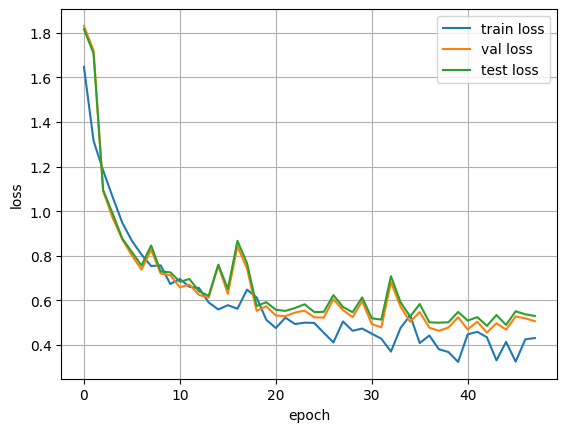

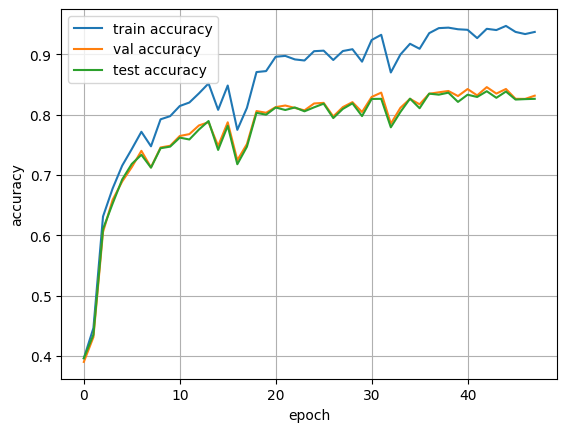

In [13]:
show_loss_through_epochs(arr_losses_train, arr_losses_test, arr_losses_val)

plt.figure()  
show_accuracy_through_epochs(arr_acc_train, arr_acc_test, arr_acc_val)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.44764107..1.7938564].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.558952..1.7502832].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.5247024..1.7938564].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.24214405..1.6369936].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.49901533..1.4079132].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.2678312..1.555955].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.43907

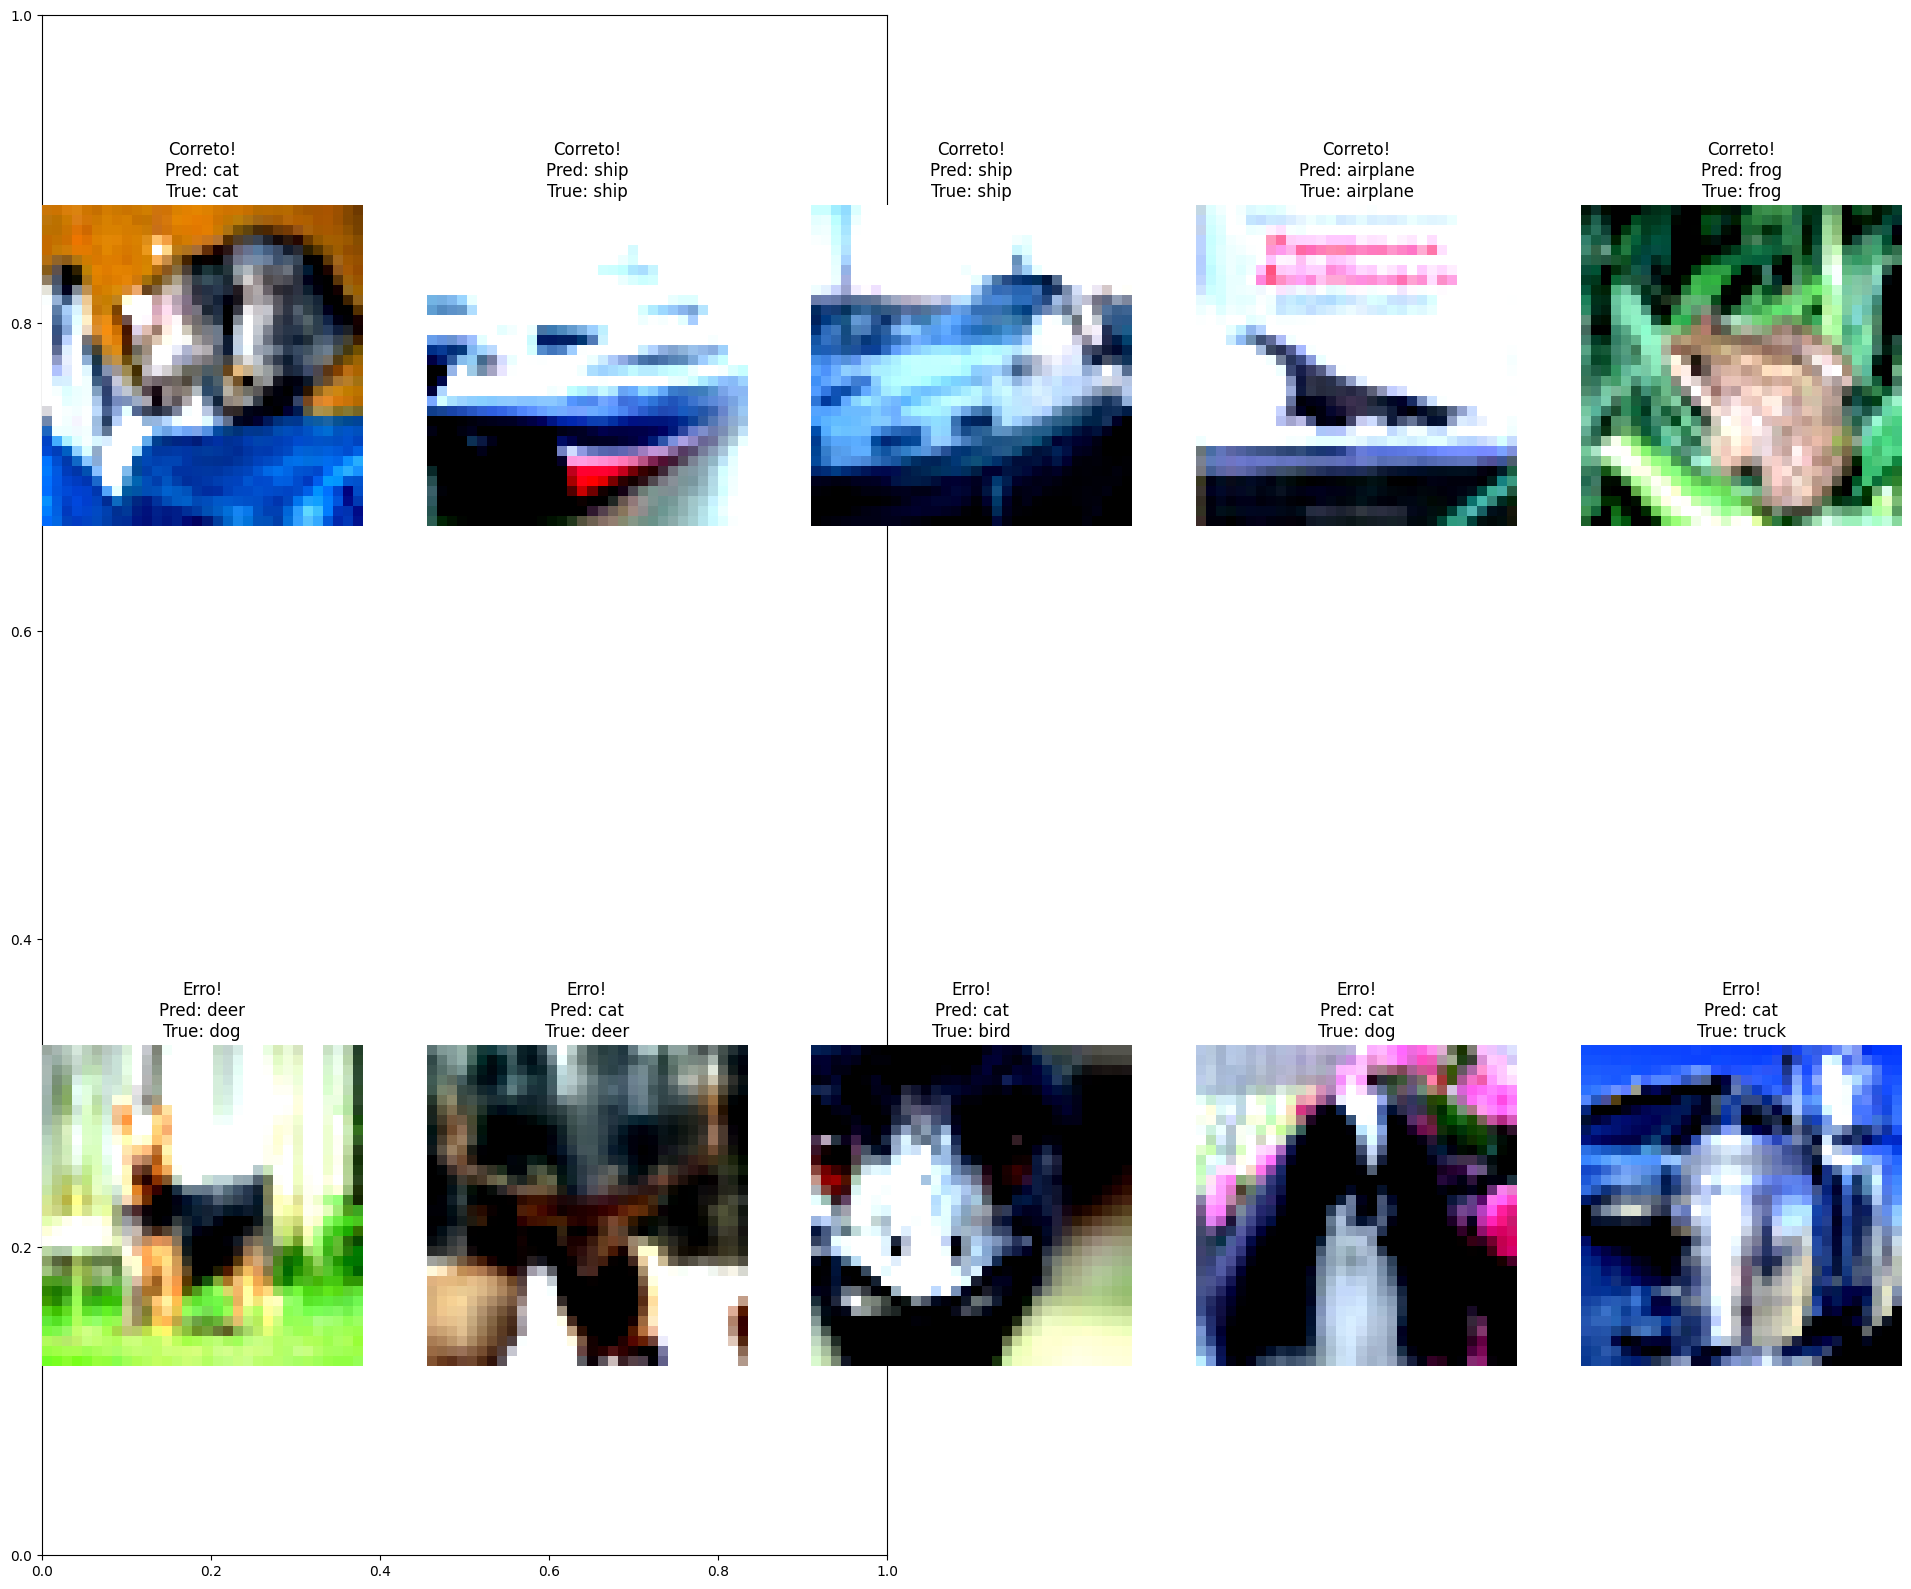

In [14]:
show_predictions(cnn, test_loader, num_samples=5)

In [15]:
cnn.eval()
predictions = []
labels = []

for images, label in test_loader:
  images = images.cuda()
  label = label.cuda()

  output = cnn(images)
  _, predicted = torch.max(output,1)

  predictions.extend(predicted.cpu().numpy())
  labels.extend(label.cpu().numpy())

scores = get_scores(labels, predictions)
print(f"Scores of your model\n {scores}\n\n")

Scores of your model
 {'accuracy': 0.8263, 'balanced_accuracy': np.float64(0.8263), 'f1_score': 0.8256443121698358, 'precision': 0.8303006779620639, 'recall': 0.8263}




In [16]:
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 
           'dog', 'frog', 'horse', 'ship', 'truck'] # .venvNN/lib/python3.12/site-packages/torchvision/prototype/datasets/_builtin/cifar10.categories

labels = np.array(labels)
predictions = np.array(predictions)

stats = {}

print(f"\n shape dataset teste -> {len(test_dataset)}")
print("\n(repr x acc top1) por classe(conjunto teste):")

for i in range(10):
    mask = labels == i
    class_acc = np.mean(predictions[mask] == labels[mask]) * 100
    num_samples = np.sum(mask)
    class_repr = (num_samples / len(labels)) * 100

    stats[classes[i]] = {
        'acuracia': f"{class_acc:.2f}%",
        'num_amostras': num_samples,
        'representatividade': f"{class_repr:.2f}%"
    }

for classe, metricas in stats.items():
    print(f"\n{classe}:")
    print(f"  Acurácia: {metricas['acuracia']}")
    print(f"  Número de amostras: {metricas['num_amostras']}")
    print(f"  Representatividade: {metricas['representatividade']}")


 shape dataset teste -> 10000

(repr x acc top1) por classe(conjunto teste):

airplane:
  Acurácia: 83.10%
  Número de amostras: 1000
  Representatividade: 10.00%

automobile:
  Acurácia: 94.70%
  Número de amostras: 1000
  Representatividade: 10.00%

bird:
  Acurácia: 75.30%
  Número de amostras: 1000
  Representatividade: 10.00%

cat:
  Acurácia: 60.70%
  Número de amostras: 1000
  Representatividade: 10.00%

deer:
  Acurácia: 85.00%
  Número de amostras: 1000
  Representatividade: 10.00%

dog:
  Acurácia: 81.00%
  Número de amostras: 1000
  Representatividade: 10.00%

frog:
  Acurácia: 92.70%
  Número de amostras: 1000
  Representatividade: 10.00%

horse:
  Acurácia: 85.50%
  Número de amostras: 1000
  Representatividade: 10.00%

ship:
  Acurácia: 88.70%
  Número de amostras: 1000
  Representatividade: 10.00%

truck:
  Acurácia: 79.60%
  Número de amostras: 1000
  Representatividade: 10.00%


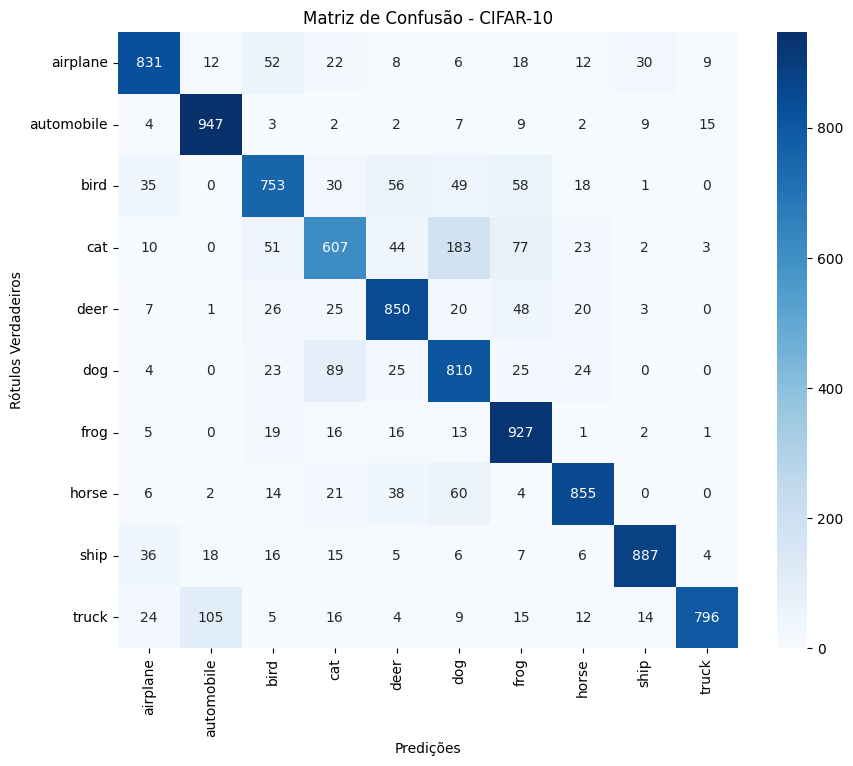

TRUE -> PRED
1. cat → dog: 183 vezes
2. truck → automobile: 105 vezes
3. dog → cat: 89 vezes
4. cat → frog: 77 vezes
5. horse → dog: 60 vezes


In [17]:
cm = metrics.confusion_matrix(labels, predictions)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.title('Matriz de Confusão - CIFAR-10')
plt.xlabel('Predições')
plt.ylabel('Rótulos Verdadeiros')
plt.show()

cm_errors = cm.copy()
np.fill_diagonal(cm_errors, 0)

flat_indices = np.argsort(cm_errors.ravel())[::-1][:5]
confusion_indices = np.unravel_index(flat_indices, cm_errors.shape)

print(f"TRUE -> PRED")
for i in range(5):
    true_class = confusion_indices[0][i]
    pred_class = confusion_indices[1][i]
    count = cm_errors[true_class, pred_class]
    if count > 0:
        print(f"{i+1}. {classes[true_class]} → {classes[pred_class]}: {count} vezes")